# PrimBHoles toolkit: 

## Index
    * Set up (load common libraries, paths, etc)
    * Powerspectrum class (side class)
    * Threshold class (side class)
    * PrimBHoles :
        * Abundances Class
        * Merger rates
        * Merger SGWB 
        * second order SGWB
        * ....
        
        

## Set up

In [1]:
import numpy as np
import scipy.constants as const
import scipy.special as special
from scipy.special import erfc
from scipy.interpolate import interp1d
import scipy.integrate as integrate
from scipy.integrate import dblquad
import scipy.optimize as opt
import matplotlib.pyplot as plt

import matplotlib as mpl


import sys, os
#ROOTPATH = os.path.abspath(os.path.join(os.path.dirname( __file__ ), '..'))
ROOTPATH = os.getcwd()
SOURCEPATH = os.path.abspath(os.path.join(ROOTPATH, 'dev'))
PARAMSPATH = os.path.abspath(os.path.join(ROOTPATH, 'params'))
PLOTSPATH = os.path.abspath(os.path.join(ROOTPATH, 'plots'))
sys.path.append(ROOTPATH)
sys.path.append(SOURCEPATH)
sys.path.append(PARAMSPATH)

from power_spectrum import PowerSpectrum
from params.user_params import physics_units, cosmo_params, PSModels_params
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription


# from baseclass import CLASSBase
# from power_spectrum import PowerSpectrum
# from threshold import ClassThresholds
# from merger_rates import MergerRates
# from abundances import CLASSabundances
from primbholes import primbholes 



#Specify the plot style
mpl.rcParams.update({'font.size': 10,'font.family':'serif'})
mpl.rcParams['xtick.major.size'] = 7
mpl.rcParams['xtick.major.width'] = 1
mpl.rcParams['xtick.minor.size'] = 3
mpl.rcParams['xtick.minor.width'] = 1
mpl.rcParams['ytick.major.size'] = 7
mpl.rcParams['ytick.major.width'] = 1
mpl.rcParams['ytick.minor.size'] = 3
mpl.rcParams['ytick.minor.width'] = 1
mpl.rcParams['xtick.direction'] = 'in'
mpl.rcParams['ytick.direction'] = 'in'
mpl.rcParams['lines.linewidth'] = 1.5
mpl.rcParams['xtick.top'] = True
mpl.rcParams['ytick.right'] = True
mpl.rcParams['font.family'] = 'serif'
mpl.rc('text', usetex=True)

mpl.rcParams['legend.edgecolor'] = 'inherit'



## Experimental

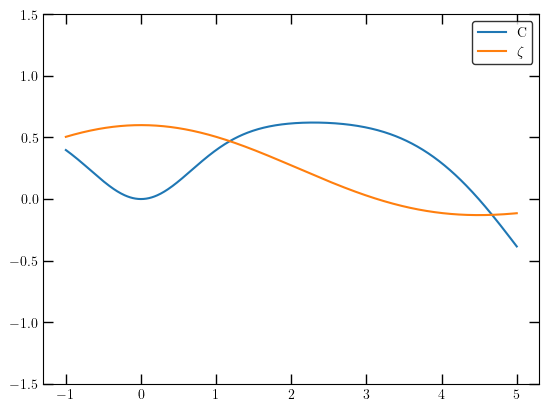

In [489]:
# what about making profile classes? 
# ZetaPorfileGauss can be a mu*sinc(kr) or other shape with amplitude 'mu'
# ZetaProfile is a funciton of ZetaProfileGauss, and has additional params: fnl, gnl, or gamma, etc. 
# Once given a profile, the class should have info on mu, (gamma,fnl, etc), and to compute/obtain  mu_c (from NR or other), Compaciton, rm, etc. 


def get_profile():
    # Do a selection option? 
    #
    return -1


def get_gaussprofile(mu=1):
    from sympy import diff, symbols, lambdify, sinc
    
    x = symbols('x')
    
    # Set zeta_G := sin(kr)/(kr)
    func = mu * sinc(x)
    dfdx = diff(func, x)
    
    # Create call-funcitons
    F =  lambdify([x], func)
    dFdx = lambdify([x], dfdx)
    
    return F, dFdx



def profile_powerseries(p_nl =[]):
    from sympy import diff, symbols, lambdify
    # form sympy import exp, sin, log, tanh
    
    x = symbols('x')
    
    # Set up function F
    func = x
    for i, i_pnl in enumerate(p_nl):
        itr = i + 2
        func += x**itr * i_pnl * (3/5)**(itr-1)
    
    # Compute derivative
    dfdg = diff(func, x)

    # Create call-functiions
    F =  lambdify([x], func)
    dFdG = lambdify([x], dfdg)
    
    return F, dFdG


def profile_logdual(gamma):
    from sympy import diff, symbols, lambdify, log
    
    x = symbols('x')
    
    # Set up function F
    if gamma !=0:
        func = -1/gamma * log(1-gamma*x)
    else:
        func = x
    
    # Compute derivative
    dfdg = diff(func, x)

    # Create call-functiions
    F =  lambdify([x], func)
    dFdG = lambdify([x], dfdg)
    
    return F, dFdG


def profile_USRwUpStep(h):
    from sympy import diff, symbols, lambdify, sqrt
    
    x = symbols('x')
    habs = np.abs(h)
    
    # Set up function F
    if gamma !=0:
        func = -1/habs * (sqrt(1-habs*x) - 1)
    else:
        func = x
    
    # Compute derivative
    dfdg = diff(func, x)

    # Create call-functiions
    F =  lambdify([x], func)
    dFdG = lambdify([x], dfdg)
    
    return F, dFdG


# def get_CompactionL_NG(r, zetag_p, dFdZg, thermalfactor=4/3):
#     out = -2*thermalfactor-zetag_p * dFdZg
#     return out

# def get_Compaction(Cl, thermalfactor=4/3):
#     out = Cl - Cl**2 / (4*thermalfactor)
#     return out

def get_CompactionNG(r, zetag_p, dFdZg, thermalfactor=2/3):
    Cl = -2*r*thermalfactor*zetag_p * dFdZg
    out = Cl - Cl**2 / (4*thermalfactor)
    return out




p = [1,1,0]
F, dFdG   = profile_powerseries(p_nl = p)

h = -0.1
F, dFdG   = profile_USRwUpStep(h)

gamma = 1
F, dFdG   = profile_logdual(gamma)




r = 10**np.linspace(-1,2,500)

r = np.linspace(-1,5,500)
z = np.sin(r)/r 

mu=0.6
ZetaGauss, ZetaGaussP = get_gaussprofile(mu)
z, zp = ZetaGauss(r), ZetaGaussP(r) 
# z = get_profilegauss(r)

Compaction = get_CompactionNG(r, ZetaGaussP(r), dFdG(ZetaGauss(r)))
# print(F(z), dFdG(z))

plt.plot(r, Compaction, label="C")
plt.plot(r, z, label=r"$\zeta$")
# plt.xscale('log')
plt.ylim(-1.5,1.5)
plt.legend()





###### Abundances (peak theory)

def MassCriticalCollapse(mu, mu_c, kstar, ZetaProfile, rm=None, K=1, p=0.36, gstar=106.75):
    
    if (mu <= mu_c): return 0   # This implies mu is a float, not a list or array. 
    
    # r = 10**np.linspace(-3,2 *np.log10(1/kstar), 1000)                   # in principle this below should be contained in Profile Class. 
    if not rm:
        r = np.linspace(0,10/kstar, 1000)
        kr = kstar* r
        ZetaGauss = get_gaussprofile(mu)
        zeta_gauss = lambda rr: ZetaGauss(kstar*rr)
        zeta = ZetaProfile(zeta_gauss(r))
        arg = np.argmax(zeta)[0]
        
        # get rm and zeta(rm)
        rm = r[arg]
        zeta_rm = zeta[arg]
    else: 
        krm = kstar* rm
        ZetaGauss = get_gaussprofile(mu)
        zeta_gauss = ZetaGauss(kstar*rm)
        zeta_rm = ZetaProfile(zeta_gauus)
        
        
    
    norm_gstar = 106.75
    norm_kstar = 1.56*1e13 # Mpc-1
    
    M_kstar = 1e20 * (gstar/norm_gstar)**(-1/6) * (kstar/norm_kstar)**-2  # grams
    
    M = K* (mu -  mu_c)**p * (kstar*rm)**2 * np.exp(2*zeta_rm) * M_kstar
    
    return M
    

def abundances_PT(M, Ag, OmegaDM0h=0.12, kstar=1.53*1e13):
    
    def _func_xi(x):
        f = 0.5*x(x**2-3)*(np.erf(0.5*np.sqrt(5/2)*x) + np.erf(np.sqrt(5/2)*x)) 
        f += np.sqrt(2/(5 * np.pi)) * ( ((8/5) + (31/4) * x**2) * np.exp(-5/8 * x**2) \
                     + ((-8/5) + 0.5*xi**2) * np.exp(-5 / 2 * xi**2))
        return f
    
    def _normal_distribution(x, sigma):
        N = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2))
        return N
        
    # Set norms
    norm_OmegaDM0h = 0.12
    norm_kstar = 1.53 * 1e13 #Mpc-1
    norm_M = 1e20 #grams
    norm_bra = 1.4e-14
    
    
#     ZetaPofile =    ??????  # this should depend on prof. params (e.g mu & gamma, or mu & fnl, etc) 
#     mu, mu_c =   ?????
    
    
    # numerical derivative
    Mass_of_mu = lambda _mu: MassCriticalCollapse(mu, mu_c, kstar, ZetaProfile)    # This should be a funciton inside Profile Class. 
    dmu = 0.001
    dMdmu = (Mass_of_mu(mu + dmu) -  Mass_of_mu(mu))/dmu
    dlnMmu = dMdmu/M
    
    fxi = __func_xi(mu/Ag**0.5)
    normaldist = _normal_distribution(mu, Ag**0.5)
    
    
    bra = dlnMdmu**-1 * fxi * normaldist
    
    out = (OmegaDM0h/norm_OmegaDM0h)**-1 * (M/norm_M) * (kstar/norm_kstar)**3 * (bra/norm_bra) 
    
    return out

    



$\mu_c$ thresholds for $\gamma$ =(-2, 0, 2) are ... 0.7798153467013623 0.6054794918108067 0.39157188734119086
print output mumax, massmax  0.899 7.097561965656023e+20 7.097561965656023e+20


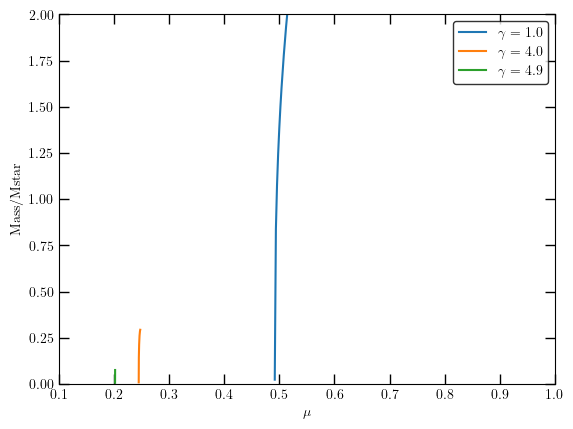

In [540]:
# Load NR threshold for log.NonGaussianity
def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        num, denom = frac_str.split('/')
        try:
            leading, num = num.split(' ')
            whole = float(leading)
        except ValueError:
            whole = 0
        frac = float(num) / float(denom)
        return whole - frac if whole < 0 else whole + frac
fn = "./data/nr_threshold.txt"
ddstr = np.loadtxt(fn, dtype=str)
th_data = np.array([[convert_to_float(d1),convert_to_float(d2)] for d1, d2 in ddstr]).T
gs, ms = th_data
mu_crit = interp1d(gs, ms) 
print(r"$\mu_c$ thresholds for $\gamma$ =(-2, 0, 2) are ...", mu_crit(-2), mu_crit(0), mu_crit(2) )



class ClassProfileLogGaussianity:
    def __init__(self, gamma, kstar, mu_c=0, rm=None):
        
        self.mu = None
        self.gamma = gamma
        self.fixed_rm = rm
        self.rm = rm
        self.mu_c = mu_c 
        self.km = kstar    # fiducial value to compute Profile and Compaction function
        
        
        self.kstar = kstar # Cosmological value used to compute Mass
        
        self.ZetaGauss = None
        self.dr_ZetaGauss = None
        self.F_of_zetaG = None
        self.derv_F_of_zetaG = None
        self.F_of_r = None
        self.derv_F_of_r = None
        self.mu_of_mass=None
        self.eff_mu_max = None
        self.eff_mass_max = None
        self.mass_max =None
        self.rm_func=None
        
        self.ProfileGaussianFunctions()
        self.ProfileNonGaussianFunctions()
        self.ProfileNonGaussianFunctionsOfRadius()
        self.get_mu_lim()
        # self.get_rm()
    
    def recompute_all(self, new_mu):
        # self.mu = new_mu
        
        self.ProfileGaussianFunctions()
        self.ProfileNonGaussianFunctions()
        self.ProfileNonGaussianFunctionsOfRadius(new_mu)
        self.get_rm(new_mu)
    
    def ProfileGaussianFunctions(self):
        from sympy import diff, symbols, lambdify, sin
        r = symbols('r')
        sym_mu = symbols('mu')

        # Set zeta_G := sin(kr)/(kr)
        func = sym_mu * sin(self.km*r) /(self.km*r)
        dfdr = diff(func, r)
        
        # Create call-funcitons
        F =  lambdify([r, sym_mu], func)
        dFdr = lambdify([r, sym_mu], dfdr)
        
        self.ZetaGauss = F
        self.dr_ZetaGauss = dFdr
        
        return F, dFdr
    
    def ProfileNonGaussianFunctions(self):
        from sympy import diff, symbols, lambdify, log, ln

        x = symbols('x') # ZetaGauss
        
        # Set up function F
        if self.gamma !=0:
            func = -1/self.gamma * ln(1-self.gamma*x)
        else:
            func = x

        # Compute derivative
        dfdg = diff(func, x)

        # Create call-functiions
        F =  lambdify([x], func)
        dFdG = lambdify([x], dfdg)
        
        self.F_of_zetaG = F
        self.derv_F_of_zetaG = dFdG

        return F, dFdG
    
    def ProfileNonGaussianFunctionsOfRadius(self):
        
        F_of_r = lambda r, sel_mu: self.F_of_zetaG(self.ZetaGauss(r, sel_mu))
        dr_F = lambda r, sel_mu: self.derv_F_of_zetaG(self.ZetaGauss(r, sel_mu)) *  self.dr_ZetaGauss(r, sel_mu)
        
        self.F_of_r = F_of_r
        self.derv_F_of_r = dr_F
                
        return F_of_r, dr_F
    
    def Compaction(self, r, sel_mu, thermalfactor=2/3):
        
        # # LISA Paper
        # ZG = lambda r: self.ZetaGauss(r, sel_mu)
        # Cl = lambda r : -2*r*thermalfactor* self.dr_ZetaGauss(r, sel_mu) * self.derv_F_of_zetaG(ZG(r))
        # C = lambda r: Cl(r) - Cl(r)**2 / (4*thermalfactor)
        
        # # Inui, CJ etal paper Eq. 2.11
        C = lambda r:  2/3 * (1 - (1 + r*self.derv_F_of_r(r, sel_mu))**2 )
                
        return C(r)
    
    def get_mu_lim(self):
        if self.gamma >= 2:
            self.mu_max= 1/self.gamma - 0.001
        elif self.gamma >=0:
            self.mu_max = 0.9
        else:
            self.mu_max= np.abs(- 4.45 / self.gamma)
            self.mu_max= self.mu_max if self.mu_max<1.2 else 1.2
        
        self.mu_min = self.mu_c 
    
    def get_rm(self, sel_mu):            
        if self.fixed_rm : return self.rm
    
        if not self.rm_func:
            def _find_rm(sel_mu):
                # TODO: This method is kind of rudomentary. Method like Newton-rhapson, could be faster. 
                
                if sel_mu*self.gamma >= 1.0 : return np.nan
                # Find latest maximum
                reff = 1/self.kstar
                r= np.linspace(reff*1e-6, 4.7 * reff, 1000)
                dr = (r[1]-r[0])*3
                r_rev = r[::-1]
                Crs_rrev = self.Compaction(r_rev, sel_mu)

                # Find the first maximum
                diff = np.diff(Crs_rrev)
                indx = np.where(diff<=0)[0][0]
                rm = r[-indx]

                # print(self.gamma, sel_mu, rm)

                r= np.linspace(rm-dr, rm+dr, 1000)
                Crs = self.Compaction(r, sel_mu)
                indx = np.argmax(Crs)
                rm = r[indx]
                return rm
            

            mus = np.linspace(0.01, self.mu_max + 0.001, 200)
            rms = np.array([ _find_rm(smu) for smu in mus])
            self.rm_func = interp1d(mus, rms)
            rm = self.rm_func(sel_mu)
            
        else: 
            rm = self.rm_func(sel_mu) 
            
        self.rm=rm
        return self.rm 
    
    def get_M_kstar(self, gstar=106.75):
        norm_gstar = 106.75
        norm_kstar = 1.56*1e13 # Mpc-1
        
        M_kstar = 1e20 * (gstar/norm_gstar)**(-1/6) * (self.kstar/norm_kstar)**-2  # grams
        return M_kstar
    
    
    def get_mass_of_mu(self, sel_mu, return_ratio=False):
        
        if sel_mu < self.mu_min:  
            print("Sub-critical perturbation, no BH!") 
            return np.nan
    
        p = 0.36
        K = 1

        M_kstar = self.get_M_kstar()
    
        # Choose rm and zeta_rm  of   selected "mu"
        rm = self.get_rm(sel_mu)
        
        
        if not rm:
            print("rm not computable, setting M=0") 
            return 0
            
        
        zeta_rm = self.F_of_r(self.rm, sel_mu)      
          
        M = K * (sel_mu -  self.mu_c)**p * (self.kstar*self.rm)**2 * np.exp(2*zeta_rm) * M_kstar

        if return_ratio: return M/M_kstar
    
        return M

    
    def get_dMdmu(self, sel_mu, return_ratio=False, df=1e-3): # Mmax=1e60, Mmin=0,
        
        M_0 = self.get_mass_of_mu(sel_mu, return_ratio=return_ratio)
        M_p1 = self.get_mass_of_mu(sel_mu +df, return_ratio=return_ratio) #assumes mu_c is unchanged

        dMdu = (M_p1 - M_0)/df
        return dMdu

    
    def get_mass_max(self, mu_max=None, return_ratio=False):
        if self.mass_max: return self.mass_max
        from scipy.interpolate import interp1d
        Func = lambda sel_mu: self.get_mass_of_mu(sel_mu, return_ratio=return_ratio)
        
        mu_max = self.mu_max
        
        mus = np.linspace(self.mu_min, mu_max - 1e-3, 500)
        Masses = np.array([Func(mui) for mui in mus])
        indx = np.nanargmax(Masses)

        eff_mumax = mus[indx]
        MassMax = Masses[indx]

        self.eff_mu_max = eff_mumax
        self.eff_mass_max = self.get_mass_of_mu(eff_mumax)
        self.mass_max = MassMax
        
        mu_of_mass = interp1d(Masses[:indx+1], mus[:indx+1])
        self.mu_of_mass= mu_of_mass
        
        return MassMax 
    
    
    
    def get_fpbh(self, M,  Ag):
        from scipy.special import erf
        def _func_xi(xi):
            f = 0.5*xi*(xi**2-3)*(erf(0.5*np.sqrt(5/2)*xi) + erf(np.sqrt(5/2)*xi)) 
            f += np.sqrt(2/(5 * np.pi)) * ( ((8/5) + (31/4) * xi**2) * np.exp(-5/8 * xi**2) \
                         + ((-8/5) + 0.5*xi**2) * np.exp(-5 / 2 * xi**2))
            return f

        def _normal_distribution(x, sigma):
            N = (1/(np.sqrt(2 * np.pi) * sigma)) * np.exp(-x**2 / (2 * sigma**2))
            return N
        

        # Set norms
        OmegaDM0h = 0.12
        norm_OmegaDM0h = 0.12
        norm_kstar = 1.53 * 1e13 #Mpc-1
        norm_M = 1e20 #grams
        norm_bra = 1.4e-14
        
        _ = self.get_mass_max() #needed to compute mu_of_mass
        mu = self.mu_of_mass(M)
        
        dlnMdmu = self.get_dMdmu(mu)/M

        fxi = _func_xi(mu/Ag**0.5)
        normaldist = _normal_distribution(mu, Ag**0.5)

        bra = np.abs(dlnMdmu)**-1 * fxi * normaldist

        out = (OmegaDM0h/norm_OmegaDM0h)**-1 * (M/norm_M) * (self.kstar/norm_kstar)**3 * (bra/norm_bra) 

        return out
    
    def get_fpbh_total(self, Ag):
        
        M_kstar = self.get_M_kstar()
        Mass_max = self.mass_max
        masses = 10**np.linspace( np.log10(M_kstar/1000) , np.log10(Mass_max - Mass_max/100) , 200) 
        fpbh = np.array([PF.get_fpbh(mass, Ag) for mass in masses])
        
        f_fpbh_on_logmass = interp1d(np.log(masses), fpbh)
        sol= integrate.quad(f_fpbh_on_logmass, np.log(masses[0]), np.log(masses[-1]),  epsrel=0.01)[0]
        fpbh_total = sol
        
        return fpbh_total
    
    def get_Ag(self, sel_fpbh_total=1, Ag_init =1e-2, Ag_min = 1e-5, abserr = 0.00001):
        
        max_iter = 500
        prev_Ag_guess = 1.
        Ag_guess = Ag_init
        for itr in range(max_iter):
            
            fpbh_total = self.get_fpbh_total(Ag_guess)
            
            error = (np.log10(fpbh_total) - np.log10(sel_fpbh_total))
            if np.abs(error) < abserr : return Ag_guess
            
            if error < 0 : # my current value is below expectation
                
                Ag_min = Ag_guess
                Ag_guess = prev_Ag_guess 
                new_Ag_guess =  10** ((np.log10(Ag_guess) + np.log10(Ag_min))/2)
                Ag_guess = new_Ag_guess
                # print(f"  > Error is {error:.3e},  setting Ag_guess = {Ag_guess:.3e}, Ag_min = {Ag_min:.3e} ")
                
            else: 
                new_Ag_guess =  10** ((np.log10(Ag_guess) + np.log10(Ag_min))/2)
        
                prev_Ag_guess = Ag_guess
                Ag_guess = new_Ag_guess
                # print(f"  > Error is {error:.3e},  setting Ag_guess = {Ag_guess:.3e}, prev_Ag = {prev_Ag_guess:.3e} ")
            
        print(f"Needed {itr} iterations,  Foud Ag = {Ag_guess} ")
        
        return Ag_guess
        
        
        
        



#pass
if True: 
    
    norm_kstar =  1.56 * 1e13
    kstar = norm_kstar
    Mstar = 1e20 * (kstar/norm_kstar )**-2

    gamma = 1
    PF = ClassProfileLogGaussianity(gamma=gamma, kstar=kstar,  mu_c=mu_crit(gamma))
    MassMax = PF.get_mass_max()  
    mu_max = PF.eff_mu_max
    mass_max = PF.mass_max
    print("print output mumax, massmax ", mu_max, mass_max, MassMax)


    dm = 0.0000001
    mus = np.linspace(mu_crit(gamma)+dm, PF.eff_mu_max,200) 
    masses = np.array([PF.get_mass_of_mu(mui) for mui in mus ])  / Mstar
    plt.plot(mus, masses, label=f'$\gamma =$ {PF.gamma:.1f}')


    gamma = 4
    PF = ClassProfileLogGaussianity(gamma=gamma, kstar=kstar, mu_c=mu_crit(gamma))
    MassMax = PF.get_mass_max() 
    mus = np.linspace(mu_crit(gamma)+dm, PF.eff_mu_max,200) 
    masses = np.array([PF.get_mass_of_mu(mui) for mui in mus ])  / Mstar
    plt.plot(mus, masses, label=f'$\gamma =$ {PF.gamma:.1f}')


    gamma = 4.9
    PF = ClassProfileLogGaussianity(gamma=gamma, kstar=kstar, mu_c=mu_crit(gamma))
    MassMax = PF.get_mass_max() 
    mus = np.linspace(mu_crit(gamma)+dm, PF.eff_mu_max,200) 
    masses = np.array([PF.get_mass_of_mu(mui) for mui in mus ])  / Mstar
    plt.plot(mus, masses, label=f'$\gamma =$ {PF.gamma:.1f}')

    # plt.yscale('log')
    plt.ylabel("Mass/Mstar")
    plt.xlabel(r"$\mu$")

    plt.ylim(0,2)
    plt.xlim(0.1, 1)
    # plt.ylim(0,0.52)
    # plt.xlim(0.2, 0.3)
    
    plt.legend()
    plt.show()        

Computing gamma = 0.0


/var/folders/1g/rr9w26j92c7814lfhsctmwh40000gn/T/ipykernel_35624/540172658.py:60: RuntimeWarning: divide by zero encountered in log10
  f_logfpbh_total = interp1d(Ags, np.log10(fpbh_total))


Computing gamma = 1.0
Computing gamma = 2.0
Computing gamma = 3.0
Computing gamma = 4.0
Computing gamma = 4.9


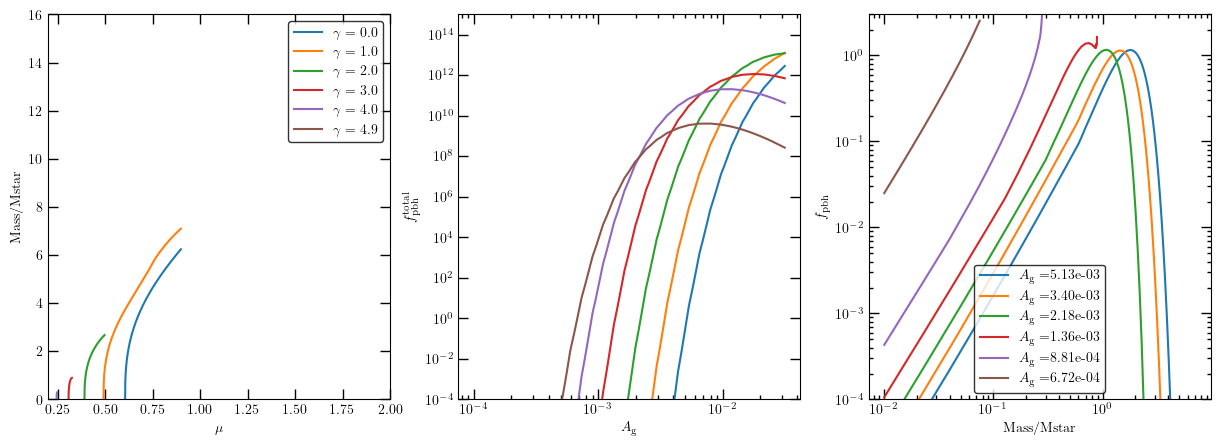

In [552]:
norm_kstar =  1.56 * 1e13
kstar = norm_kstar
Mstar = 1e20 * (kstar/norm_kstar )**-2
dm = 0.0001


rm = None

gs = np.arange(-6,4)
gs = np.arange(-6, 5.1,1)
gs = np.arange(0, 5.1,1); gs[-1]=4.9
# gs = np.arange(-6, 1 ,1)[::-1]

# gs = [2]

MU_MAX = 2


fig, axs = plt.subplots(1,3,figsize=(15,5))

for gamma in  gs:
    print(f"Computing gamma = {gamma}")
    
    mu_critical = mu_crit(gamma)
    PF = ClassProfileLogGaussianity(gamma=gamma, kstar=kstar, mu_c=mu_critical, rm=None )
    Mass_max = PF.get_mass_max()  
    mu_min = PF.mu_min
    mu_max = PF.eff_mu_max # PF.mu_max
    mu_max = mu_max if mu_max <MU_MAX else MU_MAX
    eff_mu_max = PF.eff_mu_max 
    
    
    #### PT0
    
    ax = axs[0]
    mus = 10**np.linspace(np.log10(mu_crit(gamma)), np.log10(mu_max) , 500) 
    mus[0] = mu_crit(gamma)
    masses = np.array([PF.get_mass_of_mu(mui) for mui in mus ])  / Mstar
    ax.plot(mus, masses, label=f'$\gamma =$ {PF.gamma:.1f}')
    
    
    # continue
    
    #### PT 1
    
    ax = axs[1]
    
    masses = 10**np.linspace( np.log10(Mstar/1000) , np.log10(Mass_max - Mass_max/100) , 200)    
    if gamma >= 0: Ags = 10**np.linspace(-4, -1.5, 30)      # This is slowing factor (intvl=30 is quite fast)
    if gamma < 0: Ags = 10**np.linspace(-3, -1, 30)
    fpbh_total = np.zeros_like(Ags)

    sol = 0
    for iAg, Ag in enumerate(Ags):
        if sol > 1e20 : fpbh_total[iAg] = sol; continue

        fpbh_total[iAg] =  PF.get_fpbh_total(Ag)
        sol = fpbh_total[iAg]

    f_logfpbh_total = interp1d(Ags, np.log10(fpbh_total))
    X = 10**np.linspace(np.log10(Ags[0]), np.log10(Ags[-1]), 1000)
    Y = 10**f_logfpbh_total(X)
    
    ax.plot( X, Y, label=f'$\gamma =$ {PF.gamma:.1f}')    
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    # ax.set_xlim(0.0004, 0.01)
    ax.set_ylim(0.0001, 0.1e16)
    ax.set_xlabel(r"$A_{\rm g}$")
    ax.set_ylabel(r"$f_{\rm pbh}^{\rm total}$")
    
    
    # continue 
    
    ##### PT2
    
    ax = axs[2]
    
    sel_Ag = PF.get_Ag()
    
    masses = np.linspace( Mstar/100 , Mass_max - Mass_max/100  , 200)
    fpbh = np.array([PF.get_fpbh(mass, sel_Ag) for mass in masses])
    
    ax.plot( masses/Mstar, fpbh, label=r'$A_{\rm g} =$' + f'{sel_Ag:.2e}')
    
    
    # ax.set_xlim(0.05, 7)
    ax.set_ylim(1e-4, 3)
    ax.set_yscale('log')
    ax.set_xscale('log')
    ax.set_xlabel("Mass/Mstar")
    ax.set_ylabel(r"$f_{\rm pbh}$")
    ax.legend()

    
    
    

# plt.yscale('log')
axs[0].set_ylabel("Mass/Mstar")
axs[0].set_xlabel(r"$\mu$")


axs[0].set_ylim(0,16)
axs[0].set_xlim(0.1, 1)
axs[0].set_xlim(0.2, 2)


axs[0].legend()
# axs[1].legend()
plt.show()


## PowerSpectrum

Attributes of  PS_Gaussian 
   >>    {'As': 0.003, 'kp': 5000000000.0, 'sigma': 0.3}
   >> min and max of PS:  0.0, 0.002915571749559469 


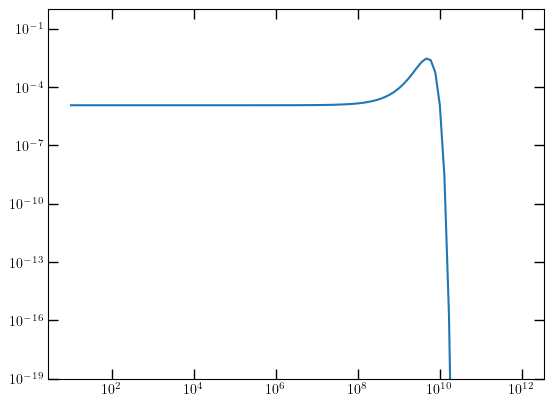

In [2]:
from power_spectrum import PowerSpectrum

# Example one model
myPS = PowerSpectrum.gaussian()

# myPS.As = 0.3
myPS.print_att()

ks = 10**np.linspace(1.0, 12.0, 100, True)   
print(f'   >> min and max of PS:  {np.min(myPS.PS(ks))}, {np.max(myPS.PS(ks))} ' )

plt.plot(ks, myPS.PS(ks))
plt.yscale("log")
plt.xscale("log")
plt.ylim(1e-19, 1)
# plt.savefig(PLOTSPATH + "/example_powerspectra_gaussian.png")
plt.show()
# plt.close()


powerlaw
Step 1b: Rescaling of the power spectrum to get f_PBH = 0.1
New scaling :  1e-05


/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:133: RuntimeWarning: divide by zero encountered in scalar divide
  beta = np.exp(-0.5*(dcrit[i_s]/sig)**2)/np.sqrt(2*np.pi*(dcrit[i_s]/sig)**2)
/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:79: RuntimeWarning: divide by zero encountered in log10
  function =  np.log10(a) -  np.log10(b)


New scaling :  100000.0


/Users/cjoana/dev/LISA-PBH-WG/dev/abundances.py:79: RuntimeWarning: invalid value encountered in log10
  function =  np.log10(a) -  np.log10(b)


New scaling :  1.0
New scaling :  0.0031622776601683794
New scaling :  0.05623413251903491
New scaling :  0.23713737056616552
New scaling :  0.4869675251658631
New scaling :  0.6978305848598664
New scaling :  0.8353625469578262
New scaling :  0.9139816994654905
New scaling :  0.9560239010953075
New scaling :  0.9347664680831878
New scaling :  0.9453354354037362
New scaling :  0.9506646468646612
New scaling :  0.9479962963359845
New scaling :  0.9466649309855664
New scaling :  0.9459999496377831
New scaling :  0.9463323819019411
New scaling :  0.9461661511699938
New scaling :  0.9462492628856798
New scaling :  0.946207706115305
New scaling :  0.9462284842723544
New scaling :  0.9462180951367958
New scaling :  0.946212900611792
New scaling :  0.9462103033599839
New scaling :  0.9462116019849968
New scaling :  0.9462109526722676
New scaling :  0.94621062801607
After rescaling, I get a total abundance of PBHs: fPBH= 0.09999871781687168
Rescaling factor= 0.94621062801607
====
broken_powerla

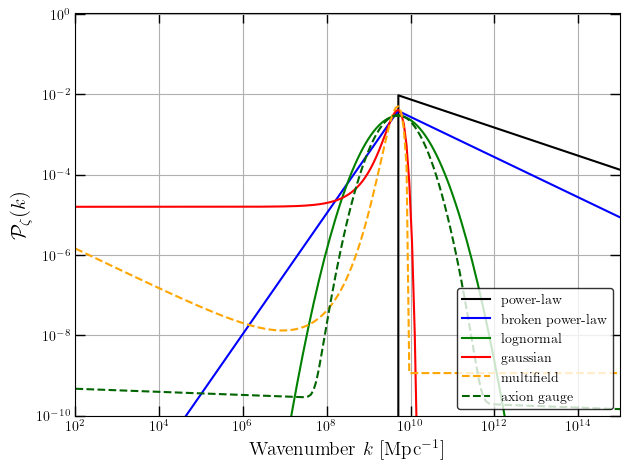

In [3]:
ComputeFPBH = True

# Example with several models
models = [ 
    'powerlaw',
    'broken_powerlaw',
    'lognormal',
    'gaussian',
    'multifield',
    'axion_gauge',
    # 'preheating',
    # 'vacuum'
]

model_name = [
    'power-law',
    'broken power-law',
    'lognormal',
    'gaussian',
    'multifield',
    'axion gauge',
    # 'preheating',   #   (2.20)
    # 'vacuum'
]

color_pal = ['k', 'b', 'g', 'r',  'orange', 'darkgreen', 'purple', 'k']
lstyle = ['-', '-', '-', '-',      '--', '--', '--', '--']


xmin = 10**2
xmax = 10**15
ymin = 1e-10
ymax = 1e0 * 1.05
k_values = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)

figPk = plt.figure()
figPk.patch.set_facecolor('white')
ax = figPk.add_subplot(111)

scale =1 

for i, model in enumerate(models):
    PM = PowerSpectrum.get_model(model)
    # PM.kp=5e6
    # print('set kp to', PM.kp)
    ps_function = PM.PS
    
    print(model)
    ifpbh = ""
    if ComputeFPBH:
        if model=="vacuum": continue
        pb = primbholes(ps_function=ps_function, fpbh_rescaling=0.1)
        ifpbh = np.round(pb.get_integrated_fPBH(), 2)
        scale = pb.get_spectrum_scaling()
    
    xs = k_values
    ys = PM.PS(kk=k_values)   * scale  
    lbl = f"{model_name[i]}"
    ax.plot(xs, ys, label=lbl, color=color_pal[i], ls=lstyle[i])

ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel('Wavenumber $k$  [Mpc$^{-1}$]', fontsize=14)
plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$', fontsize=15)

plt.legend(loc=4)
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOTSPATH + "/example_powerspectra_models.png", dpi=300)
plt.show()


After rescaling, I get a total abundance of PBHs: fPBH= 1.0004890912864883
Rescaling factor= 0.317517128631511

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9998851435809062
Rescaling factor= 2.9369655047216514

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9996394049047383
Rescaling factor= 0.12092675313074892

====

scaling :  1.567039854036664
After rescaling, I get a total abundance of PBHs: fPBH= 0.9999582853654736
Rescaling factor= 1.567039854036664

====

After rescaling, I get a total abundance of PBHs: fPBH= 0.9997040229497783
Rescaling factor= 0.10525102491756518

====

After rescaling, I get a total abundance of PBHs: fPBH= 1.0000573476724959
Rescaling factor= 0.12104099141699594

powerlaw
broken_powerlaw
lognormal
gaussian
multifield
axion_gauge


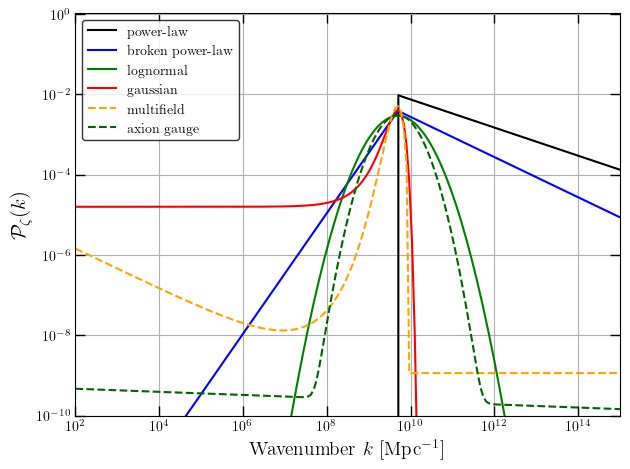

In [3]:
ComputeFPBH = False

# Example with several models
models = [ 
    'powerlaw',
    'broken_powerlaw',
    'lognormal',
    'gaussian',
    'multifield',
    'axion_gauge',
    # 'preheating',
    # 'vacuum'
]

model_name = [
    'power-law',
    'broken power-law',
    'lognormal',
    'gaussian',
    'multifield',
    'axion gauge',
    # 'preheating',   #   (2.20)
    #'vacuum'
]

scales = [
0.94621062801607, 3.862320053155609, 0.14105680262395384,  1.3626696793470874, 0.5739895427438906, 0.15146162777820546    
]

color_pal = ['k', 'b', 'g', 'r',  'orange', 'darkgreen', 'purple', 'k']
lstyle = ['-', '-', '-', '-',      '--', '--', '--', '--']


xmin = 10**2
xmax = 10**15
ymin = 1e-10
ymax = 1e0 * 1.05
k_values = 10**np.linspace(np.log10(xmin), np.log10(xmax), 200)

figPk = plt.figure()
figPk.patch.set_facecolor('white')
ax = figPk.add_subplot(111)

scale =1 

for i, model in enumerate(models):
    PM = PowerSpectrum.get_model(model)
    # PM.kp=5e6
    # print('set kp to', PM.kp)
    ps_function = PM.PS
    
    print(model)
    ifpbh = ""
    if ComputeFPBH:
        if model=="vacuum": continue
        pb = primbholes(ps_function=ps_function, fpbh_rescaling=0.1)
        ifpbh = np.round(pb.get_integrated_fPBH(), 2)
        scale = pb.get_spectrum_scaling()
    
    scale = scales[i]
    
    xs = k_values
    ys = PM.PS(kk=k_values)   * scale  
    lbl = f"{model_name[i]}"
    ax.plot(xs, ys, label=lbl, color=color_pal[i], ls=lstyle[i])

ax.set_xscale('log')
ax.set_yscale('log')
plt.ylim(ymin,ymax)
plt.xlim(xmin,xmax)
plt.xlabel('Wavenumber $k$  [Mpc$^{-1}$]', fontsize=14)
plt.ylabel(r'$\mathcal{P}_{\zeta} (k)$', fontsize=15)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(PLOTSPATH + "/example_powerspectra_models.png", dpi=300)
plt.show()

## Threshold

In [3]:
from power_spectrum import PowerSpectrum
from params.user_params import physics_units, cosmo_params, PSModels_params
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription

###### Set mass example:

Msun = physics_units.m_sun
# mPBH = Msun * 1.0
mPBH = 1.0

###### Set model example: 

PS_model = PowerSpectrum.axion_gauge()    
PS_func =  PS_model.PS_plus_vacuum


### Print threshold 

print(" ")
print("Example using Standard formalism:  ")
deltacrit = ClassThresholdsStandard(PS_func=PS_func)

dc = deltacrit.get_deltacr()
dc_thermal = deltacrit.get_deltacr_with_thermalhistory(mPBH)
print(" >> delta crit without / with thermal history ", dc, dc_thermal)

print("\n")
print("Example using Shape Prescription formalism: ")
deltacrit = ClassThresholdsShapePrescription(ps_function=PS_func)

dc = deltacrit.get_deltacr()
dc_thermal = deltacrit.get_deltacr_with_thermalhistory(mPBH)
print(" >> delta crit without / with thermal history ", dc, dc_thermal)

print("\n")
print("Issue: methods give very diferent threshold values. ")


## TODO: save shape parameter, and funtion to print it

 
Example using Standard formalism:  
 >> delta crit without / with thermal history  0.5 0.4618490480716858


Example using Shape Prescription formalism: 


/Users/cjoana/dev/LISA-PBH-WG/dev/threshold.py:177: IntegrationWarning: The maximum number of subdivisions (1000) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  integ = integrate.quad(integrand, 0, np.inf, limit=1000, limlst=100)


Exception: failed to converge in get_rm iteration

In [4]:
from threshold import ClassThresholdsStandard, ClassThresholdsShapePrescription

AsPBH, kp, sigma = [0.0205, 2.e6, 1.]       ## This example works fine! 
# AsPBH, kp, sigma = [0.0205, 2.e6, 0.5]    ## This example crashes...          # TODO: method need some testing! 

def PS_func(kk):
        return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))


method = ClassThresholdsShapePrescription(ps_function=PS_func)

dc = method.get_deltacr()

print(" >> delta critical is ", dc)

 >> delta critical is  0.8694606172753746


## PrimBHoles 

### Abundances

In [5]:
pb = primbholes()

##Example:
## Model A: Gaussian
sig =  0.25
As = 0.01*sig
kp = 1e6
ps_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Select with vacuum
ps_func =  ps_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

pb.set_powerspectrum(ps_function=ps_func)

pb = primbholes(ps_function=ps_func)
# pb = CLASSabundances(ps_function = ps_func, threshold_method="standard")

mass = 10**np.linspace(-6,8, 30)  #* Msun
fpbh = pb.get_fPBH(mass)

floor = 1e-8
beta = pb.get_beta(mass)  #+ floor
fpbh = pb.get_fPBH(mass)  + floor
sigma = pb.get_variance(mass)

# dc = pb.get_deltacr()  ## TODO: not implemented yet in the primbholes class


print(f"fPBH = {fpbh}")

print(" >> delta critical is ", dc)

fPBH = [1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000053e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08 1.00000000e-08 1.00000000e-08
 1.00000000e-08 1.00000000e-08]
 >> delta critical is  0.8694606172753746


 INTEGRATED fPBH is 9.48512602084463e-19


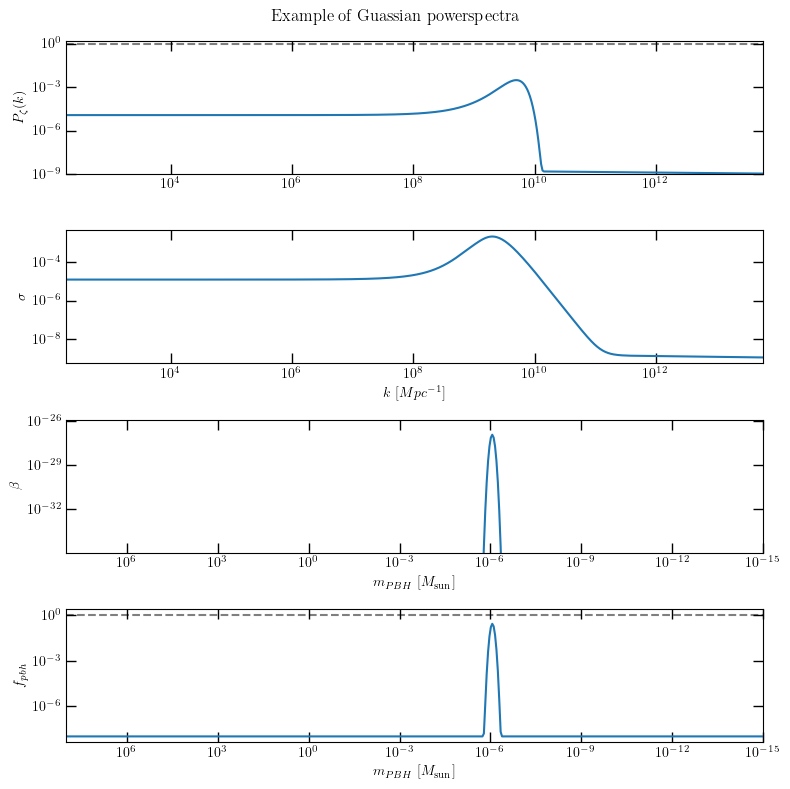

In [6]:
def k_of_m(mass):
    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6
    mH = mass / ratio_mPBH_over_mH
    kk = kmsun / mH ** (0.5)  # S. Clesse: to be checked
    return kk

def m_of_k(k):

    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6

    mass = (kmsun/k)**2 *  ratio_mPBH_over_mH
    return mass


test = 0
Msun = physics_units.m_sun

# Model A: Gaussian
sig =  0.3
As = 0.01*sig
kp = 5e9
PS_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Model B : axion_gauge
# PS_model = PowerSpectrum.axion_gauge()    
# PS_model = PowerSpectrum.axion_gauge(As=As, sigma=sig, kp=kp)

# ## Model C : multi_field
# kf = 5e9             # scale H-crossing at sharp turn  [mpc^-1]
# P0 = 2e-9 * 0.5739895427438906    # Amplitude Pk in absence of transient instability
# eta = 3.             # TODO: check value
# delta = 2.5          # TODO: check value
# kp = kf
# PS_model = PowerSpectrum.multifield()    
# PS_model = PowerSpectrum.multifield(kf=kf, eta=eta, delta=delta)


## Select with vacuum
PS_func =  PS_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

## Select threshold calc method
a = primbholes(ps_function = PS_func, threshold_method="standard")    # a = CLASSabundances(ps_function = PS_func, threshold_method="standard")
# a = primbholes(ps_function = PS_func, threshold_method="ShapePrescription")   # a = CLASSabundances(ps_function = PS_func, threshold_method="ShapePrescription")   

## Params range: 
mass = 10**np.linspace(-15,8, 500)  #* Msun
floor = 1e-8

# Compute quantities
beta = a.get_beta(mass)  #+ floor
fpbh = a.get_fPBH(mass)  + floor
sigma = a.get_variance(mass)

fpbh_total = a.get_integrated_fPBH()

print(f" INTEGRATED fPBH is {fpbh_total}")



##### Make Plot 

fig, axs = plt.subplots(4,1, figsize=(8,8))

fig.suptitle("Example of Guassian powerspectra")
kk =  k_of_m(mass)
ax = axs[0]
ax.plot(kk, PS_func(kk))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xlim(min(kk), max(kk))


ax = axs[1]
ax.plot(kk, sigma)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")
ax.set_xlim(min(kk), max(kk))

ax = axs[2]
ax.plot(mass, beta)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))
ax.set_ylim(beta.max()*1e-8, beta.max()*10)

ax = axs[3]
ax.plot(mass, fpbh)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$f_{pbh}$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_abundances.png")
# plt.show()

### Merger rates

/var/folders/1g/rr9w26j92c7814lfhsctmwh40000gn/T/ipykernel_94126/1208240360.py:82: RuntimeWarning: divide by zero encountered in log10
  Z =  np.log10(sol).T
/var/folders/1g/rr9w26j92c7814lfhsctmwh40000gn/T/ipykernel_94126/1208240360.py:99: RuntimeWarning: divide by zero encountered in log10
  Z =  np.log10(sol).T


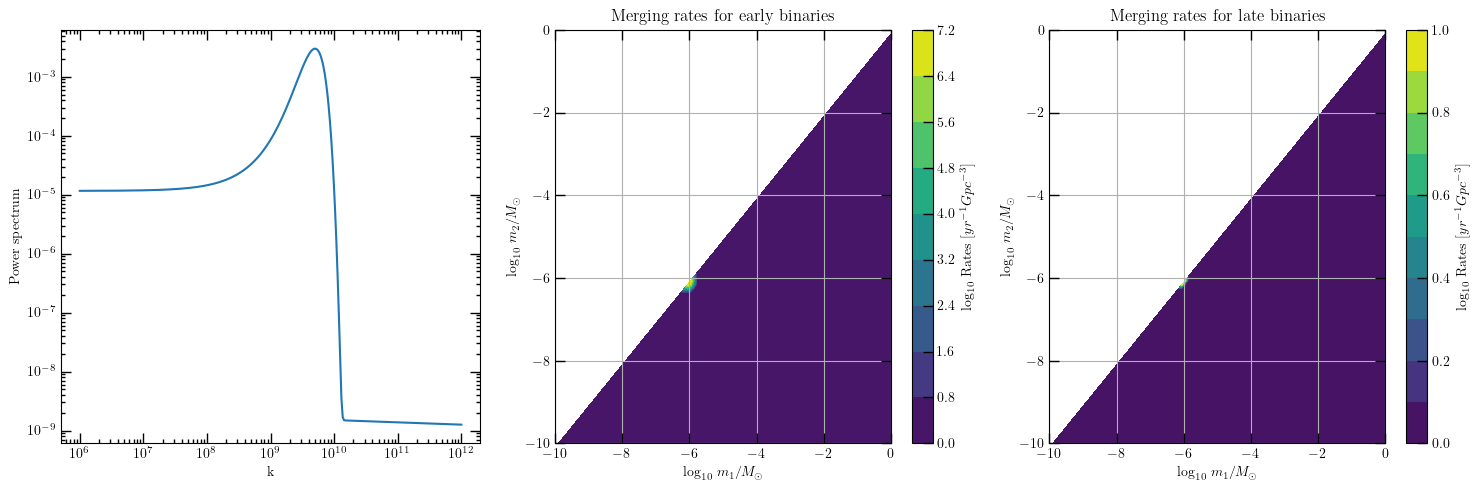

In [7]:
from power_spectrum import PowerSpectrum
from merger_rates import MergerRates
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

# masses =  10**np.linspace(-10,10, 1000)  

# PS_model = PowerSpectrum.gaussian(kp=2.e6, As=0.0205, sigma=1.)
# PS_func =  PS_model.PS

# def PS_func(kk):
#     AsPBH, kp, sigma = [0.003, 2.e6, 1.]
    
#     sigma =  0.25
#     AsPBH = 0.01#*sigma
#     kp = 1e7
#     # AsPBH *= 1.183767
    
#     # sigma =  0.3
#     # AsPBH = 0.01*sig
#     # kp = 5e9
    
#     # AsPBH, kp, sigma = [0.0025, 2.e6, 1.]
#     return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))

# ks = 10**np.linspace(2,10, 300) 
# plt.plot(ks , PS_func(ks))
# plt.ylim(1e-10, 2)
# plt.ylabel("Power spectrum")
# plt.xlabel("k")
# plt.xscale("log")
# plt.yscale("log")
# plt.show()


# def m_of_k(k):

#     ratio_mPBH_over_mH = 0.8
#     kmsun = 2.1e6

#     mass = (kmsun/k)**2 *  ratio_mPBH_over_mH
#     return mass

# masses = m_of_k(ks)[::-1]

# pb =  primbholes(ps_function=PS_func)   #  CLASSabundances(ps_function=PS_func)
# fpbhs = pb.get_fPBH(masses)
# fpbh_integrated =  pb.get_integrated_fPBH()



masses =  10**np.linspace(-10,0, 100)  


# Model A: Gaussian
sig =  0.3
As = 0.01*sig
kp = 5e9
PS_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)
PS_func =  PS_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

ks = 10**np.linspace(6,12, 300)
fig, axs = plt.subplots(1,3, figsize=(15,5)) 
ax = axs[0]
ax.plot(ks , PS_func(ks))
# ax.set_ylim(1e-10, 2)
ax.set_ylabel("Power spectrum")
ax.set_xlabel("k")
ax.set_xscale("log")
ax.set_yscale("log")

my_abundances = primbholes(ps_function=PS_func)
fpbhs = my_abundances.get_fPBH(masses)
fpbh_integrated =  1 # my_abundances.get_integrated_fPBH()     ### NEEDS FIX


# EARLY BINARIES

sol = MergerRates().get_rates_early_binaries(fpbh_integrated, masses, fpbhs) 

ax = axs[1]
Z =  np.log10(sol).T
floor = 0.0
Z[(Z<floor)] = floor
cs=ax.contourf(np.log10(masses),np.log10(masses),Z, levels=10) 
ax.set_xlabel(r'$\log_{10} \, m_1 /M_\odot $')
ax.set_ylabel(r'$\log_{10} \, m_2 /M_\odot $')
ax.set_title("Merging rates for early binaries")
cbar = fig.colorbar(cs)
cbar.set_label(r'log$_{10}$ Rates  [$yr^{-1}Gpc^{-3}$]', rotation=90)
ax.grid(True)


# LATE BINARIES

sol = MergerRates().get_rates_late_binaries(fpbh_integrated, masses, fpbhs) 

ax = axs[2]
Z =  np.log10(sol).T
floor = 0.0
Z[(Z<floor)] = floor
cs=ax.contourf(np.log10(masses),np.log10(masses),Z, levels=10) 
ax.set_xlabel(r'$\log_{10} \, m_1 /M_\odot $')
ax.set_ylabel(r'$\log_{10} \, m_2 /M_\odot $')
ax.set_title("Merging rates for late binaries")
cbar = fig.colorbar(cs)
cbar.set_label(r'log$_{10}$ Rates  [$yr^{-1}Gpc^{-3}$]', rotation=90)
ax.grid(True)

plt.tight_layout()
plt.show()

### Merger SGWB    (needs testing)

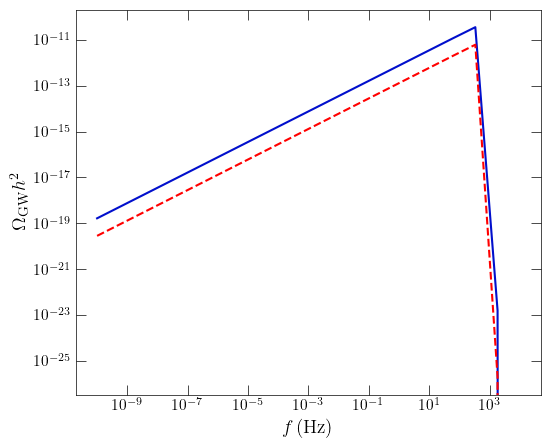

In [17]:
from power_spectrum import PowerSpectrum
from abundances import CLASSabundances
from merger_rates import MergerRates
from merger_SGWB import Backgrounds
import matplotlib.pyplot as plt
from matplotlib import ticker, cm


masses =  10**np.linspace(-3,4, 100)  

def PS_func(kk):
    AsPBH, kp, sigma = [0.0025, 2.e6, 1.]
    # AsPBH *= 1.183767
    return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))

my_abundances = CLASSabundances(ps_function=PS_func)
fpbhs = my_abundances.get_fPBH(masses)
fpbh_integrated = 1


my_abundances = CLASSabundances(ps_function=PS_func)
fpbhs = my_abundances.get_fPBH(masses)
fpbh_integrated = 1 
sol = MergerRates().get_rates_late_binaries(fpbh_integrated, masses, fpbhs)
my_backgrounds = Backgrounds(my_abundances)

logfmin=-10
logfmax=4
nfreq=20
GWB_EB=np.zeros(nfreq)
GWB_LB=np.zeros(nfreq)
listfreq =  np.logspace(logfmin,logfmax,nfreq)    

GWB_EB = my_backgrounds.Get_GW_bkg_early_binaries(listfreq)
GWB_LB = my_backgrounds.Get_GW_bkg_late_binaries(listfreq)  

fig, ax = plt.subplots(1,1, figsize=(6, 5)) 

ax.tick_params(axis='both', which='both', labelsize=11, direction='in', width=0.5) 
ax.xaxis.set_ticks_position('both') 
ax.yaxis.set_ticks_position('both') 
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(0.5)
plt.loglog(listfreq, GWB_EB, linestyle= 'solid', label = 'Total EB',color = '#010fcc')
plt.loglog(listfreq, GWB_LB, linestyle= 'dashed', label = 'Total LB',color = 'red')    
plt.xlabel(r"$f \thinspace\rm{(Hz)}$",fontsize = 14)
plt.ylabel(r"$\Omega_{\rm{GW}} h^2$", fontsize = 14)
plt.show()


### 2nd Order SGWB

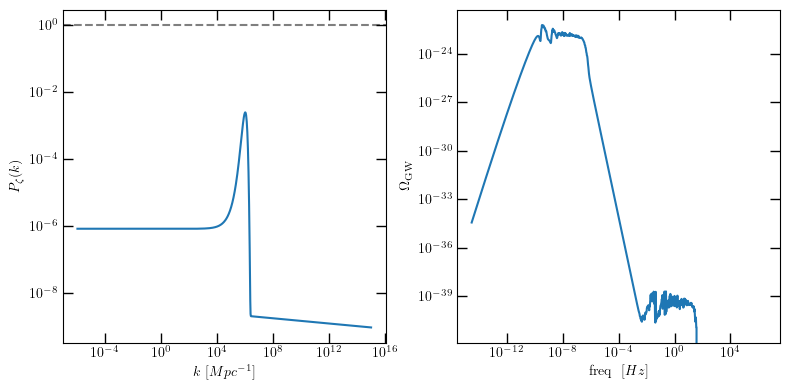

In [18]:
from second_order_SGWB import SecondOrderSGWB

# ## Model A: Gaussian
# sig =  0.25
# As = 0.01*sig
# kp = 1e7
# ps_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Model B : axion_gauge
# ps_model = PowerSpectrum.axion_gauge()    
# ps_model = PowerSpectrum.axion_gauge(As=As, sigma=sig, kp=kp)

## Select with vacuum
ps_func =  ps_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)

kvals = 10**np.linspace(-6,15, 1000)

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)   
## SOGW = pb.get_2ndOrderGWs(ps_function=PS_func)                 ## TODO: not implemented yet in the primbhole class

kvals = 10**np.linspace(-6,15, 1000)  


fig, axs = plt.subplots(1,2, figsize=(8,4))
###################################################

ax = axs[0]
x = kvals
y = ps_func(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")
# ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)
###################################################

ax = axs[1]
x = SOGW.get_frequencies(kvals)
y = SOGW.get_OmegaGWs(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\Omega_{\rm GW}$")
ax.set_xlabel(r"freq $\ [Hz]$")
# ax.set_ylim(1e-9, 1.5)
# ax.axhline(1, color="k", ls="--", alpha=0.5)

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_2ndOrderSGWB.png", dpi=300)

plt.show()

## Test Model powerlaw

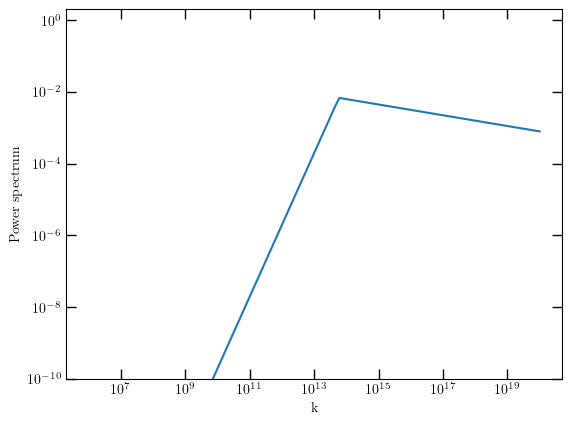

/var/folders/1g/rr9w26j92c7814lfhsctmwh40000gn/T/ipykernel_94126/2233821689.py:40: RuntimeWarning: divide by zero encountered in log10
  Z =  np.transpose(np.log10(sol))


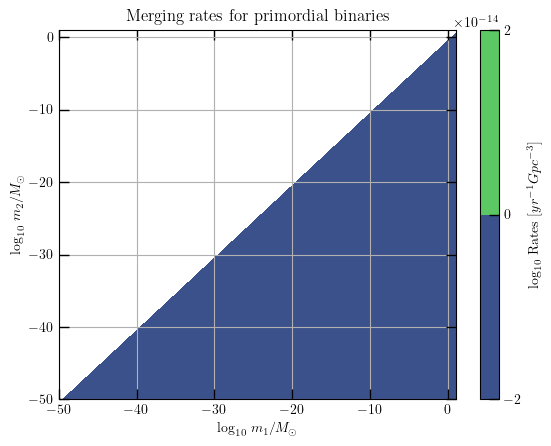

In [16]:
from power_spectrum import PowerSpectrum
from merger_rates import MergerRates
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

masses =  10**np.linspace(-50,1, 100)  

# PS_model = PowerSpectrum.gaussian(kp=2.e6, As=0.0205, sigma=1.)
# PS_func =  PS_model.PS


sig =  0.2
As = 0.02*sig
kp = 5e13

PS_model = PowerSpectrum.broken_powerlaw(As_low=5e-3, As_high=7e-3, 
                                         kp_low=kp, kp_high=kp, ns_low=3, ns_high=0.85, kc=kp)

PS_func = PS_model.PS

ks = 10**np.linspace(6,20, 100) 
plt.plot(ks , PS_func(ks))
plt.ylim(1e-10, 2)
plt.ylabel("Power spectrum")
plt.xlabel("k")
plt.xscale("log")
plt.yscale("log")
plt.show()

pb =  primbholes(ps_function=PS_func)   #  CLASSabundances(ps_function=PS_func)
fpbhs = pb.get_fPBH(masses)
fpbh_integrated = pb.get_integrated_fPBH()

sol = MergerRates().get_rates_late_binaries(fpbh_integrated, masses, fpbhs) 
# sol = pb.get_rates_late_binaries(masses, fpbhs)                       # TODO : currently don't work (problem with class inheritance) 

figRprim = plt.figure()
# figRprim.patch.set_facecolor('white')
ax = figRprim.add_subplot(111)
Z =  np.transpose(np.log10(sol))
floor = 0.0
Z[(Z<floor)] = floor
cs=ax.contourf(np.log10(masses),np.log10(masses),Z, levels=10) 
plt.title("Merging rates for primordial binaries")
cbar = figRprim.colorbar(cs)
cbar.set_label(r'log$_{10}$ Rates  [$yr^{-1}Gpc^{-3}$]', rotation=90)
#ax.set_xscale('log')
#ax.set_yscale('log')
#plt.ylim(1.e-4,1.e1)
plt.xlabel(r'$\log_{10} \, m_1 /M_\odot $')
plt.ylabel(r'$\log_{10} \, m_2 /M_\odot $')
plt.grid(True)
# figRprim.savefig(PLOTSPATH + "/example_RatesPrim.png", facecolor=figRprim.get_facecolor(), edgecolor='none',dpi=300)
plt.show()

In [ ]:
from power_spectrum import PowerSpectrum
from abundances import CLASSabundances
from merger_rates import MergerRates
from merger_SGWB import Backgrounds
import matplotlib.pyplot as plt
from matplotlib import ticker, cm

masses =  10**np.linspace(-25,-10, 100)  

# PS_model = PowerSpectrum.gaussian(kp=2.e6, As=0.0205, sigma=1.)
# PS_func =  PS_model.PS

# def PS_func(kk):
#     AsPBH, kp, sigma = [0.0025, 2.e6, 1.]
#     # AsPBH *= 1.183767
#     return AsPBH * np.exp(- np.log(kk / kp) ** 2 / (2 * sigma ** 2))

my_abundances = CLASSabundances(ps_function=PS_func)
fpbhs = my_abundances.get_fPBH(masses)
sol = MergerRates().get_rates_clusters(masses, fpbhs)
my_backgrounds = Backgrounds(my_abundances)

logfmin=-13
logfmax=-4
nfreq=20
GWB_EB=np.zeros(nfreq)
GWB_LB=np.zeros(nfreq)
listfreq =  np.logspace(logfmin,logfmax,nfreq)    

GWB_EB = my_backgrounds.Get_GW_bkg_primordial_binary(listfreq)
GWB_LB = my_backgrounds.Get_GW_bkg_cluster_binary(listfreq)  

fig, ax = plt.subplots(1,1, figsize=(6, 5)) 

ax.tick_params(axis='both', which='both', labelsize=11, direction='in', width=0.5) 
ax.xaxis.set_ticks_position('both') 
ax.yaxis.set_ticks_position('both') 
for axis in ['top','bottom','left','right']: 
    ax.spines[axis].set_linewidth(0.5)
plt.loglog(listfreq, GWB_EB, linestyle= 'solid', label = 'Total EB',color = '#010fcc')
plt.loglog(listfreq, GWB_LB, linestyle= 'dashed', label = 'Total LB',color = 'red')    
plt.xlabel(r"$f \thinspace\rm{(Hz)}$",fontsize = 14)
plt.ylabel(r"$\Omega_{\rm{GW}} h^2$", fontsize = 14)
plt.show()


In [ ]:
from second_order_SGWB import SecondOrderSGWB

# ## Model A: Gaussian
# sig =  0.25
# As = 0.01*sig
# kp = 1e7
# ps_model = PowerSpectrum.gaussian(As=As, sigma=sig, kp=kp)

## Model B : axion_gauge
# ps_model = PowerSpectrum.axion_gauge()    
# ps_model = PowerSpectrum.axion_gauge(As=As, sigma=sig, kp=kp)

## Select with vacuum
ps_func = PS_func   # ps_model.PS_plus_vacuum        # This is the default to calculate sigma and fPBH

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)

kvals = 10**np.linspace(-6,20, 1000)

# Call the class 
SOGW = SecondOrderSGWB(ps_function=ps_func)   
## SOGW = pb.get_2ndOrderGWs(ps_function=PS_func)                 ## TODO: not implemented yet in the primbhole class

kvals = 10**np.linspace(-6,20, 1000)  


fig, axs = plt.subplots(1,2, figsize=(8,4))
###################################################

ax = axs[0]
x = kvals
y = ps_func(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")
# ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)
###################################################

ax = axs[1]
x = SOGW.get_frequencies(kvals)
y = SOGW.get_OmegaGWs(kvals)
###################
ax.plot(x, y)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\Omega_{\rm GW}$")
ax.set_xlabel(r"freq $\ [Hz]$")
# ax.set_ylim(1e-9, 1.5)
# ax.axhline(1, color="k", ls="--", alpha=0.5)

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_2ndOrderSGWB.png", dpi=300)

plt.show()

## Checks

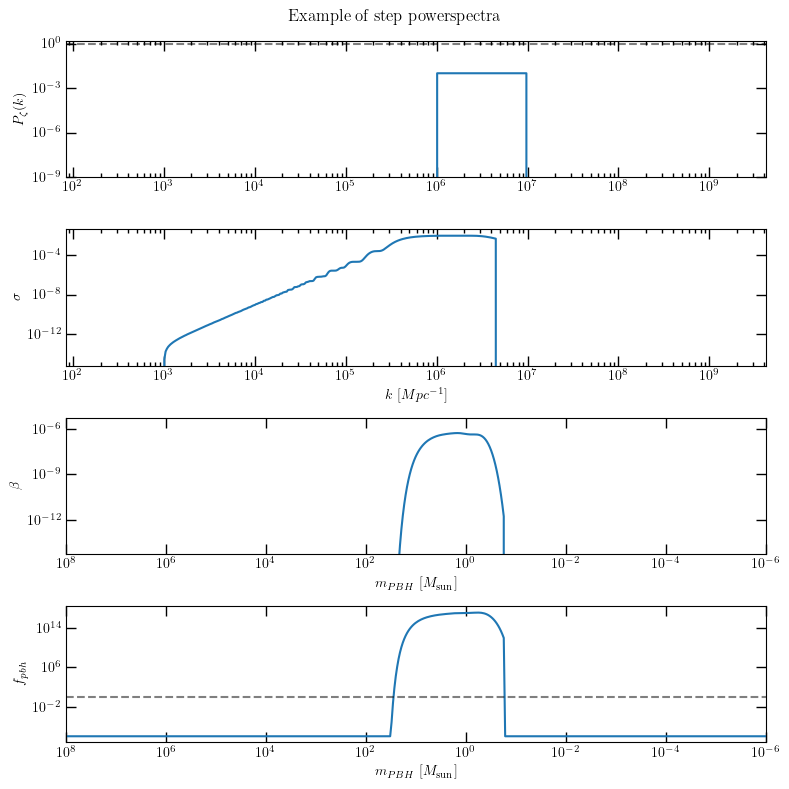

In [24]:
def k_of_m(mass):
    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6
    mH = mass / ratio_mPBH_over_mH
    kk = kmsun / mH ** (0.5)  # S. Clesse: to be checked
    return kk
def m_of_k(k):

    ratio_mPBH_over_mH = 0.8
    kmsun = 2.1e6

    mass = (kmsun/k)**2 *  ratio_mPBH_over_mH
    return mass




test = 0
Msun = physics_units.m_sun



# def PS_func(k, ma=1e-2, mb=1e2):
    
#     kk = k 
#     out = np.zeros_like(kk)
#     a = k_of_m(ma)
#     b = k_of_m(mb)
#     mask = ((kk<=a) & (kk>=b))
#     out[mask] = 1
#     mask = ((kk>=a) & (kk<=b))
#     out[mask] = 1
    
#     return out * 0.01


def PS_func(k, a=1e6, b=1e7):
    
    kk = k 
    out = np.zeros_like(kk)
    mask = ((kk<=a) & (kk>=b))
    out[mask] = 1
    mask = ((kk>=a) & (kk<=b))
    out[mask] = 1
    
    return out * 0.01
    
    
    
    
    
## Select threshold calc method
a = primbholes(ps_function = PS_func, threshold_method="standard")    # a = CLASSabundances(ps_function = PS_func, threshold_method="standard")
# a = primbholes(ps_function = PS_func, threshold_method="ShapePrescription")   # a = CLASSabundances(ps_function = PS_func, threshold_method="ShapePrescription")   

## Params range: 
mass = 10**np.linspace(-6,8, 500)  #* Msun
floor = 1e-8

# Compute quantities
beta = a.get_beta(mass)  #+ floor
fpbh = a.get_fPBH(mass)  + floor
sigma = a.get_variance(mass)


##### Make Plot 

fig, axs = plt.subplots(4,1, figsize=(8,8))

fig.suptitle("Example of step powerspectra")
kk =  k_of_m(mass)
ax = axs[0]
ax.plot(kk, PS_func(kk))
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$P_\zeta(k)$")
ax.set_ylim(1e-9, 1.5)
ax.axhline(1, color="k", ls="--", alpha=0.5)


ax = axs[1]
ax.plot(kk, sigma)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\sigma$")
ax.set_xlabel(r"$k\ [Mpc^{-1}]$")

ax = axs[2]
ax.plot(mass, beta)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$\beta$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))
ax.set_ylim(beta.max()*1e-8, beta.max()*10)

ax = axs[3]
ax.plot(mass, fpbh)
ax.axhline(1, color="k", ls="--", alpha=0.5)
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$f_{pbh}$")
ax.set_xlabel(r"$m_{PBH}\ [M_{\rm sun}]$")
ax.set_xlim(max(mass), min(mass))

plt.tight_layout()
# plt.savefig(PLOTSPATH + "/example_abundances.png")
plt.show()